# Visualize note distribution for MAESTRO_small

* Load all training dataset from MAESTRO_small
* Divide all data into segments
* Count num_onset for all segments and keep the results
* Visualize results in histogram

In [1]:
import sys
import matplotlib.pyplot as plt
import pretty_midi
import soundfile as sf
import torch
import numpy as np
import glob
import math
import IPython.display as ipd
import pytsmod as tsm
import librosa
import librosa.display
from torch.utils.data import DataLoader

In [2]:
from onsets_and_frames.dataset import MAESTRO_scaled 
# from onsets_and_frames import *
from train_wo_sacred import collate_scaled_audio

In [3]:
SAMPLE_RATE = 16000
HOP_LENGTH = SAMPLE_RATE * 32 // 1000
ONSET_LENGTH = SAMPLE_RATE * 32 // 1000
OFFSET_LENGTH = SAMPLE_RATE * 32 // 1000
HOPS_IN_ONSET = ONSET_LENGTH // HOP_LENGTH
HOPS_IN_OFFSET = OFFSET_LENGTH // HOP_LENGTH
MIN_MIDI = 21
MAX_MIDI = 108

N_MELS = 229
MEL_FMIN = 30
MEL_FMAX = SAMPLE_RATE // 2
WINDOW_LENGTH = 2048

SCALE = 1.3
SEGMENT_FRAMES = 100

# x, sr = sf.read('/home/haemin/Documents/gct634_final/data/MAESTRO/2006/MIDI-Unprocessed_01_R1_2006_01-09_ORIG_MID--AUDIO_01_R1_2006_02_Track02_wav.flac', dtype='int16')
data_path = '/home/haemin/Documents/gct634-ai613-2021/onsets-and-frames/data/MAESTRO_small'
sequence_length = 200 * HOP_LENGTH

## Load all training data from MAESTRO_small

In [4]:
train_dataset = MAESTRO_scaled(path=data_path, groups=['train'], sequence_length=sequence_length)

num_train = len(train_dataset)
print(num_train)

Loading 1 group of MAESTRO_scaled at /home/haemin/Documents/gct634-ai613-2021/onsets-and-frames/data/MAESTRO_small


Loading group train: 100%|█████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 224.25it/s]

100


## Retrieve all number of onsets for every segments

Dividing and counting are all implemented using Dataset & DataLoader

In [13]:
# Initialize loader
batch_size = 5
loader = DataLoader(train_dataset, batch_size, shuffle=False, collate_fn=collate_scaled_audio, drop_last=True)

# Total number of segments in training dataset
# num_segment = sequence_length // (HOP_LENGTH * SEGMENT_FRAMES)
# total_segment_num = num_train * num_segment
num_batch = num_train // batch_size
total_segment_onset = []

# Get data with dataloader
for i, data in enumerate(loader):    # every batch
    batch_num_onsets = data['num_onsets']    # (batch_size, 2)
    total_segment_onset.append(batch_num_onsets)
    
total_segment_onset = torch.stack(total_segment_onset).flatten()
# total_segment_onset = total_segment_onset.flatten()
print(total_segment_onset.shape)
print(total_segment_onset)

/home/haemin/anaconda3/envs/gct634_final/lib/python3.8/site-packages/librosa/filters.py:238: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn(


torch.Size([200])
tensor([ 5.,  7.,  6.,  6.,  9., 11.,  6.,  4.,  4.,  7.,  7.,  9., 11.,  7.,
         8.,  6., 10., 10.,  5., 10.,  8.,  8.,  4.,  5.,  4.,  2.,  5.,  7.,
         8., 11.,  3.,  4.,  5.,  3.,  6.,  4.,  7.,  8.,  8.,  7.,  6.,  9.,
         5.,  7., 12., 10., 10.,  8., 12., 10.,  6., 11.,  7.,  5.,  9.,  8.,
         6.,  8.,  7.,  5., 10.,  9.,  9., 10., 10., 10., 10.,  9., 11., 10.,
         8.,  9., 11., 10.,  5.,  7.,  6.,  7., 12., 10., 11., 10., 12., 10.,
        10., 11.,  5.,  4.,  7.,  8.,  9.,  9.,  9.,  5., 11., 11.,  7.,  6.,
         3.,  4.,  9., 13., 10.,  8.,  6.,  5., 11., 12.,  1.,  2.,  8.,  6.,
        11., 12.,  4.,  5.,  4.,  1.,  6.,  5., 10., 12., 13.,  5.,  0.,  3.,
        12., 10.,  6.,  6.,  6., 12.,  8.,  5.,  6.,  6.,  5.,  6.,  2.,  1.,
         9.,  8., 10., 12.,  4.,  3.,  5.,  4.,  8.,  2.,  6.,  9.,  5., 11.,
         7.,  3., 10.,  9.,  3.,  3., 11., 10.,  9.,  8.,  8., 10.,  6.,  8.,
        10., 10., 12.,  6.,  5.,  5.,  7.,  7.

## Plot values in histogram

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
[0.00420931 0.01026107 0.02197695 0.04135575 0.06837509 0.09932384
 0.12676596 0.1421495  0.14004951 0.12123037 0.09220082 0.06161008
 0.03617115 0.01865805 0.00845598]
[0.09220082 0.06161008 0.03617115 0.01865805 0.00845598]
0.21709608510561582


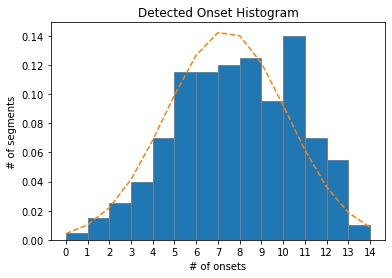

In [49]:
vis_total_segment_onset = total_segment_onset.numpy().astype('int32')
vis_bin = np.arange(0, max(vis_total_segment_onset+2), 1)
# print(bins)
# print(vis_total_segment_onset)

# Statistics from the data
mu = np.mean(vis_total_segment_onset)  # mean of distribution
sigma = np.std(vis_total_segment_onset)  # standard deviation of distribution

fig, ax = plt.subplots()
counts, bins, patches = ax.hist(vis_total_segment_onset, bins=vis_bin, edgecolor='gray', density=True)
ax.set_xticks(bins)
fig.gca().set(title='Detected Onset Histogram', xlabel= '# of onsets', ylabel='# of segments');

# add a 'best fit' line
y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
     np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
print(bins)
print(y)
ax.plot(bins, y, '--')

print(y[-5:])
print(np.sum(y[-5:]))